In [30]:
import pandas as pd
import numpy as np
import re
from sklearn.metrics.pairwise import cosine_similarity
from matplotlib import pyplot as plt
import collections
import xgboost as xgb
from sklearn import cross_validation
%matplotlib inline

### Считывание данных

In [2]:
data = pd.read_csv('superjob.csv')
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 1000)

In [3]:
data.head(400)

,Unnamed: 0,new_pos,salary,pos_1,len_pos_1,pos_2,len_pos_2,pos_3,len_pos_3,pos_4,len_pos_4,pos_5,len_pos_5
0,0,"Финансовый менеджер, Финансовый аналитик",40000,Фрилансер,10 месяцев,Московский государственный университет им. М.В...,NaN,Московский государственный университет им. М.В...,NaN,NaN,NaN,NaN,NaN
1,1,Специалист по работе с государственными контра...,50000,Секретарь,2 месяца,Преподаватель информатики,2 года и 9 месяцев,Преподаватель информатики,7 лет,"Ведущий экономист, экономист",6 лет и 7 месяцев,Повар,6 лет и 5 месяцев
2,2,Аналитик,40000,"Контент-менеджер, логист, пеший курьер",2 года и 9 месяцев,Ведущий экономист,7 лет и 8 месяцев,Луганский национальный аграрный университет,NaN,NaN,NaN,NaN,NaN
3,3,Аналитик,0,"Главный специалист, начальник отдела",5 лет,Руководитель,4 года и 10 месяцев,Заведующий лабораторией корпоративных финансов,9 лет и 6 месяцев,"Старший аналитик (электроэнергетика, телекомму...",2 года и 3 месяца,Начальник управления фондовых операций,1 год и 2 месяца
4,4,Аналитик бизнес-процессов-Консультант / Програ...,0,"Эксперт-аналитик, инженер-программист Visual F...",1 год,Начальник отдела программирования,7 месяцев,"Эксперт-аналитик, инженер-программист Visual F...",2 года и 2 месяца,Инженер-программист Visual Foxpro,1 год и 6 месяцев,Инженер-программист Visual Foxpro,5 лет
5,5,Аналитик данных / Data Scientist,0,Репетитор,8 лет и 5 месяцев,"Редактор, разработчик",2 года и 8 месяцев,Московский физико-технический институт (госуда...,NaN,Московский физико-технический институт (госуда...,NaN,NaN,NaN
6,6,Математик-аналитик,90000,Учитель математики,1 год и 6 месяцев,Учитель математики,3 месяца,Доцент кафедры математических методов в управл...,14 лет и 1 месяц,Доцент кафедры высшей математики,4 года и 9 месяцев,"Ученый консультант, начальник отдела, заместит...",21 год и 3 месяца
7,7,"Бизнес-аналитик 1С, менеджер IT-проектов",0,Аналитик бизнес-процессов,5 лет и 9 месяцев,Сервисный инженер,2 года,NaN,NaN,NaN,NaN,NaN,NaN
8,8,"Аналитик, экономист-аналитик по менеджменту, п...",0,Инспектор станции отдела транспортной безопасн...,4 года и 2 месяца,Серийный предприниматель / Руководитель,12 лет и 1 месяц,"Менеджер региона, Коммерческий представитель",5 лет и 10 месяцев,Коммерческий директор,3 года и 5 месяцев,"Научный сотрудник, младший научный сотрудник, ...",8 лет и 7 месяцев
9,9,Бизнес-аналитик,75000,Директор,5 месяцев,Руководитель направления управления бизнес-про...,2 года и 2 месяца,Эксперт Департамента планирования и клиентской...,7 лет и 1 месяц,Специалист Управления по развитию бизнеса,2 года и 8 месяцев,Ведущий специалист Управления внешних связей,5 лет и 9 месяцев


In [4]:
data.shape

(2152, 13)

### Преобразование данных

In [5]:
data_nrml = data.copy()

Пододвигаем часть таблицы

In [6]:
for itr_col in range(data_nrml.shape[1]-1, 0, -1):
    data_nrml[data_nrml.columns[itr_col]][347:] = data_nrml[data_nrml.columns[itr_col-1]][347:]

In [7]:
data_nrml.drop(data_nrml.columns[0], axis=1, inplace=True)

In [8]:
for itr in range(data_nrml.shape[0]):
    if data_nrml['salary'][itr] == '0':
        data_nrml['salary'][itr] = np.nan
    else:
        data_nrml['salary'][itr] = int(data_nrml['salary'][itr])

Удаляем строки, состоящие из NaN

In [9]:
data_nrml.dropna(axis='rows', how='all', inplace=True)

Удаляем должность, если занимаемый срок NaN

In [10]:
data_nrml.reset_index(inplace=True)
data_nrml.drop(data_nrml.columns[0], axis=1, inplace=True)

In [11]:
for itr_col in range(3, data_nrml.shape[1], 2):
    for itr_row in range(data_nrml.shape[0]):
        if pd.isna(data_nrml[data_nrml.columns[itr_col]][itr_row]):
            data_nrml[data_nrml.columns[itr_col-1]][itr_row] = np.nan

Переводим занимаемый срок из строки в число дней

In [12]:
def cnt_days(text):
    if pd.isna(text):
        return np.nan
    else:
        text_y = ''
        text_m = ''
        if 'и' in text:
            text_y = text[:text.index('и')]
            text_m = text[text.index('и')+1:]
        elif ('год' in text) or ('лет' in text):
            text_y = text
        elif ('месяц' in text):
            text_m = text

        num_y = 0
        num_m = 0
        if text_y != '':
            num_y = int("".join(filter(str.isdigit, text_y)))
        if text_m != '':
            num_m = int("".join(filter(str.isdigit, text_m)))

        return (num_y * 360 + num_m * 30)

In [13]:
def col_cnt_days(col):
    for itr in range(col.shape[0]):
        col[itr] = cnt_days(col[itr])

In [14]:
%%time
col_cnt_days(data_nrml['len_pos_1'])
col_cnt_days(data_nrml['len_pos_2'])
col_cnt_days(data_nrml['len_pos_3'])
col_cnt_days(data_nrml['len_pos_4'])
col_cnt_days(data_nrml['len_pos_5'])

CPU times: user 344 ms, sys: 28.5 ms, total: 372 ms
Wall time: 347 ms


Удаляем еще пару столбцов

In [15]:
data_nrml.drop(data_nrml.columns[0], axis=1, inplace=True)
data_nrml.drop(data_nrml.columns[0], axis=1, inplace=True)

Преобразуем должности в вектора

In [17]:
%%time
from gensim.models import KeyedVectors
# load the google word2vec model
filename = 'ruwikiruscorpora_upos_skipgram_300_2_2018.vec'
model = KeyedVectors.load_word2vec_format(filename, binary=False)

CPU times: user 1min 32s, sys: 1.26 s, total: 1min 33s
Wall time: 1min 34s


In [18]:
data_nrml.dropna(axis='rows', how='all', inplace=True)
data_nrml.reset_index(inplace=True)
data_nrml.drop(data_nrml.columns[0], axis=1, inplace=True)

In [19]:
def dist_betw_sent(sent1, sent2):
    if pd.isna(sent1) or pd.isna(sent2):
        return np.nan
    else:
        words1 = re.sub(r'[^\w\s]','',sent1).split()
        words2 = re.sub(r'[^\w\s]','',sent2).split()
        vec1 = np.zeros(300)
        for word in words1:
            if (word + '_NOUN') in model:
                vec1 += model[word + '_NOUN']
        vec2 = np.zeros(300)
        for word in words2:
            if (word + '_NOUN') in model:
                vec2 += model[word + '_NOUN']
        return float(cosine_similarity([vec1], [vec2])[0])

In [20]:
def col_dist(col1, col2):
    for itr in range(col1.shape[0]):
        col2[itr] = dist_betw_sent(col1[itr], col2[itr])

In [21]:
%%time
data_tmp = data_nrml[pd.notna(data_nrml['pos_2'])]
data_tmp.reset_index(inplace=True)
data_tmp.drop(data_tmp.columns[0], axis=1, inplace=True)
y = data_tmp.len_pos_1.values
col_dist(data_tmp['pos_1'], data_tmp['pos_2'])
col_dist(data_tmp['pos_1'], data_tmp['pos_3'])
col_dist(data_tmp['pos_1'], data_tmp['pos_4'])
col_dist(data_tmp['pos_1'], data_tmp['pos_5'])
X = np.vstack((data_tmp['len_pos_2'].values,\
               data_tmp['len_pos_3'].values,\
               data_tmp['len_pos_4'].values,\
               data_tmp['len_pos_5'].values,\
               data_tmp['pos_2'].values,\
               data_tmp['pos_3'].values,\
               data_tmp['pos_4'].values,\
               data_tmp['pos_5'].values,\
              ))

/Users/aleksandrkim/anaconda3/lib/python3.5/site-packages/pandas/core/frame.py:3694: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)
/Users/aleksandrkim/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/Users/aleksandrkim/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/aleksandrkim/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:7

CPU times: user 3min 51s, sys: 1.17 s, total: 3min 52s
Wall time: 3min 55s


In [35]:
X = X.T

### Построение моделей

In [26]:
y

array([60, 990, 1800, 360, 3030, 540, 2070, 1500, 150, 90, 120, 450, 210,
       90, 1440, 180, 210, 750, 810, 270, 210, 330, 840, 1440, 480, 1500,
       2610, 270, 270, 1290, 1050, 810, 240, 540, 450, 120, 4080, 1080,
       4740, 120, 750, 990, 270, 1410, 60, 270, 1830, 750, 2160, 420, 150,
       210, 390, 180, 390, 2790, 150, 720, 180, 450, 930, 1290, 3060, 120,
       90, 1080, 30, 60, 1020, 450, 1890, 1890, 1890, 540, 1290, 3540,
       3540, 3540, 3540, 570, 1680, 1680, 630, 3030, 1620, 270, 2250, 4890,
       840, 330, 1560, 660, 660, 870, 270, 240, 5640, 4590, 2130, 3330,
       210, 930, 480, 330, 240, 2070, 180, 2010, 2010, 690, 150, 450, 240,
       3240, 930, 3870, 1530, 1080, 180, 1740, 420, 570, 180, 180, 180,
       180, 60, 1140, 390, 450, 3210, 480, 2190, 2130, 390, 210, 180, 5850,
       420, 1050, 270, 180, 540, 540, 2610, 240, 1050, 1290, 210, 780, 240,
       240, 150, 60, 210, 330, 120, 420, 90, 1860, 480, 540, 300, 120,
       1020, 960, 750, 660, 510, 150, 270

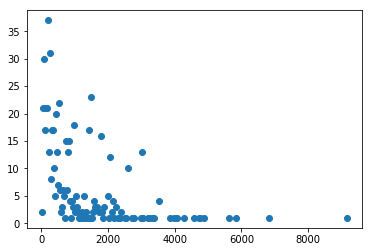

In [31]:
d = collections.defaultdict(int)
for value in y:
    d[value]+=1
plt.scatter(d.keys(), d.values());

In [32]:
y_k = ((y >= 1500) * 1)

In [33]:
xgb_model_k = xgb.XGBClassifier(
    max_depth=10, 
    n_estimators=200, 
    learning_rate=0.03, 
    objective='binary:logistic', 
    seed=42 
    )

In [42]:
roc_auc_k = cross_validation.cross_val_score(xgb_model_k, X, y_k, scoring='roc_auc', cv=3).mean()

In [43]:
roc_auc_k

0.84645158299726508

Проверка

In [53]:
algo = xgb_model_k.fit(X, y_k)

In [39]:
y_pred = xgb_model_k.predict(X)

In [40]:
print(y[:15])
print(y_pred[:15])

[60 990 1800 360 3030 540 2070 1500 150 90 120 450 210 90 1440]
[0 0 1 0 1 0 1 1 0 0 0 0 0 0 0]


In [1]:
## сохраним модель

In [56]:
# algo.booster().save_model('xgboost_model')
import pickle
pickle.dump(xgb_model_k, open("xgboost_model", "wb"))
# loaded_model = pickle.load(open("xgb.pickle.dat", "rb"))

In [61]:
l = ['Аналитик','Директор по информационным технологиям',
 '7 месяцев',
 'Руководитель направления прикладных систем',
 '2 года',
 'Руководитель отдела автоматизации',
 '1 год',
 'Руководитель ИТ службы (Директор по ИТ), Руководитель ИТ проектов',
 '6 лет и 9 месяцев']